In [601]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, roc_curve, auc, RocCurveDisplay
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN



In [602]:
data = pd.read_csv('../data/processed/data.csv')


In [603]:
X = data[[column for column in list(data.columns) if column not in ['label', 'session_id', 'new_label','acceleration_pos_neg_ratio','acceleration_std','clicks_count', 'time_morning','durations','hover_frequency','speed_cv']]]
y = data[['new_label']]
#y = data[['label']]

In [604]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

Define function to add Gaussian noise

In [605]:
def add_gaussian_noise(X, noise_level=0.1):
    noise = np.random.normal(loc=0.0, scale=noise_level, size=X.shape)
    return X + noise

In [606]:
# Define k values to test
k_values = [3, 5, 7, 9]

#### Testing oversampling techniques

#### 1. SMOTE

#### With CV

In [607]:


# K-Fold setup
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_k = None
best_cv_score = 0.0

# Search for best k using cross-validation
for k in k_values:
    knn_pipe = Pipeline([
        ('scaler', StandardScaler()), 
        ('smote', SMOTE(sampling_strategy='minority', random_state=42)), 
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    
    cv_scores = cross_val_score(knn_pipe, X_train, y_train, cv=kfold, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)
    
    print(f"k={k}: Mean CV Accuracy = {mean_cv_score:.4f} ± {np.std(cv_scores):.4f}")
    
    if mean_cv_score > best_cv_score:
        best_cv_score = mean_cv_score
        best_k = k

print(f"\nBest k: {best_k} with CV Accuracy = {best_cv_score:.4f}")

# Fit final model with best k on full training set
final_knn_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)), 
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])

final_knn_pipe.fit(X_train, y_train)

# Predict on test set
y_pred = final_knn_pipe.predict(X_test)
y_prob = final_knn_pipe.predict_proba(X_test)[:, 1]

# Evaluate test performance
test_accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"\nTest set accuracy (best k={best_k}): {test_accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(final_knn_pipe.named_steps['knn'].classes_)

k=3: Mean CV Accuracy = 0.9703 ± 0.0188
k=5: Mean CV Accuracy = 0.9666 ± 0.0215
k=7: Mean CV Accuracy = 0.9666 ± 0.0215
k=9: Mean CV Accuracy = 0.9703 ± 0.0188

Best k: 3 with CV Accuracy = 0.9703

Test set accuracy (best k=3): 0.9722
ROC AUC: 0.9834
['bot' 'human']


/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected

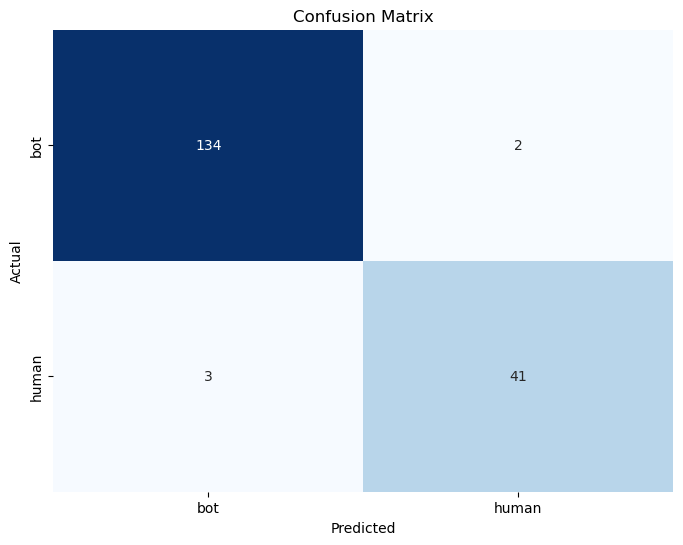

In [608]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), cbar=False)

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [609]:
# 2. F1 Score
f1 = f1_score(y_test, y_pred, average='micro') # Get global avg across all classes
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9722


#### 2. Borderline SMOTE

#### With CV

In [610]:


# K-Fold setup
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_k = None
best_cv_score = 0.0

# Search for best k using cross-validation
for k in k_values:
    knn_pipe = Pipeline([
        ('scaler', StandardScaler()), 
        ('smote', BorderlineSMOTE(sampling_strategy='minority', random_state=42)), 
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    
    cv_scores = cross_val_score(knn_pipe, X_train, y_train, cv=kfold, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)
    
    print(f"k={k}: Mean CV Accuracy = {mean_cv_score:.4f} ± {np.std(cv_scores):.4f}")
    
    if mean_cv_score > best_cv_score:
        best_cv_score = mean_cv_score
        best_k = k

print(f"\nBest k: {best_k} with CV Accuracy = {best_cv_score:.4f}")

# Fit final model with best k on full training set
final_knn_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('smote', BorderlineSMOTE(sampling_strategy='minority', random_state=42)), 
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])

final_knn_pipe.fit(X_train, y_train)

# Predict on test set
y_pred = final_knn_pipe.predict(X_test)
y_prob = final_knn_pipe.predict_proba(X_test)[:, 1]

# Evaluate test performance
test_accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"\nTest set accuracy (best k={best_k}): {test_accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(final_knn_pipe.named_steps['knn'].classes_)

/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


k=3: Mean CV Accuracy = 0.9740 ± 0.0189
k=5: Mean CV Accuracy = 0.9703 ± 0.0222
k=7: Mean CV Accuracy = 0.9592 ± 0.0318
k=9: Mean CV Accuracy = 0.9555 ± 0.0381

Best k: 3 with CV Accuracy = 0.9740

Test set accuracy (best k=3): 0.9778
ROC AUC: 0.9811
['bot' 'human']


/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected

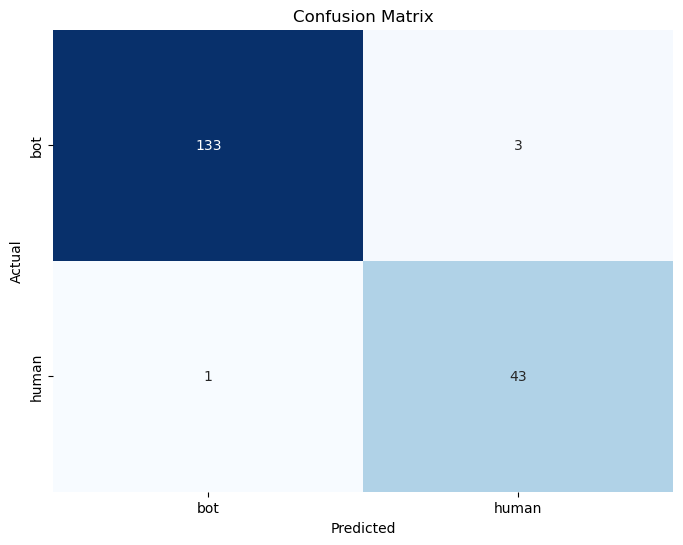

In [611]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), cbar=False)

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### 3. ADASYN

#### With CV

In [612]:


# K-Fold setup
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_k = None
best_cv_score = 0.0

# Search for best k using cross-validation
for k in k_values:
    knn_pipe = Pipeline([
        ('scaler', StandardScaler()), 
        ('smote', ADASYN(sampling_strategy='minority', random_state=42)), 
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    
    cv_scores = cross_val_score(knn_pipe, X_train, y_train, cv=kfold, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)
    
    print(f"k={k}: Mean CV Accuracy = {mean_cv_score:.4f} ± {np.std(cv_scores):.4f}")
    
    if mean_cv_score > best_cv_score:
        best_cv_score = mean_cv_score
        best_k = k

print(f"\nBest k: {best_k} with CV Accuracy = {best_cv_score:.4f}")

# Fit final model with best k on full training set
final_knn_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('smote', ADASYN(sampling_strategy='minority', random_state=42)), 
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])

final_knn_pipe.fit(X_train, y_train)

# Predict on test set
y_pred = final_knn_pipe.predict(X_test)
y_prob = final_knn_pipe.predict_proba(X_test)[:, 1]

# Evaluate test performance
test_accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"\nTest set accuracy (best k={best_k}): {test_accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(final_knn_pipe.named_steps['knn'].classes_)

/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected

k=3: Mean CV Accuracy = 0.9814 ± 0.0117
k=5: Mean CV Accuracy = 0.9814 ± 0.0117
k=7: Mean CV Accuracy = 0.9777 ± 0.0138
k=9: Mean CV Accuracy = 0.9740 ± 0.0189

Best k: 3 with CV Accuracy = 0.9814

Test set accuracy (best k=3): 0.9778
ROC AUC: 0.9811
['bot' 'human']


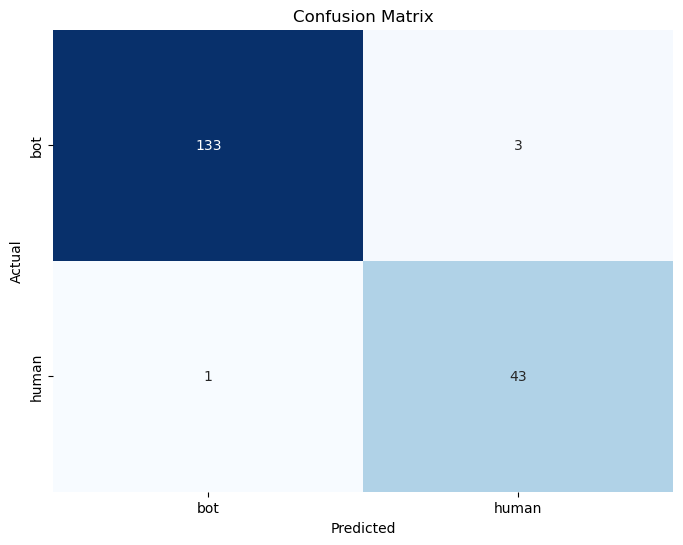

In [613]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), cbar=False)

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()